### <center><h1 style="font-size:40px;">Exercise I:<br> Backpropagation in Numpy
</h1></center>

---


Welcome to the first lab assignment!

In this lab, we will scratch the surface of deep learning. For this purpose, we start with implementing and training a shallow network with the help of Numpy to get an idea of how a neural network works.

In the lab assignment, all tasks tagged with **TODO's**  are expected to be done before the deadline. The assignments also include **Question** which should be answered and included in the report to be submitted before the deadline. Note that some sections do not involve any **TODO's**, however, we encourage you to visit them to understand the remaining concept. 


Good luck!

---

## Perceptron
A neuron, in the simplest form, is a perceptron, which can solve binary problems, in other words, problems that can be solved with a linear function.

The math for the perceptron or a single neuron is defined as; $y(x,w) = g(\sum_{k=1}^{n} w_{k}x_{k} + b)$ where $g$ is an activation function to introduce non-linearity into the output of a neuron. For the image below, the concept of bias is used, which corresponds to $b$ in the equation above.



<img align="center" width="600" src="../data/images/perceptron.png">

## MLP
We can connect more perceptrons together and define a multi-layer perceptron (MLP) that consists of at least one one hidden layer. Each layer in this MLP structure can involve multiple neurons. 

In this lab assignment, we will create a Feedforward Multilayer network to be trained using the backpropagation algorithm (SGD together with the chain rule). The MLP will have the sigmoid activation function (binary) between the hidden layers and the final layer  will consist of a softmax (multi-class) activation function to classify the given input. 


<img align="center" width="600" src="../data/images/MLP.PNG">

## Imports
We start with importing the required libs

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torchvision
import torch
import pytest

# Load dataset
The first step is to import the dataset. Here, we initially focus on the digits dataset from sklearn.

In [3]:
digits = load_digits()

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now, we plot some sample data just to make sure that the data is loaded!

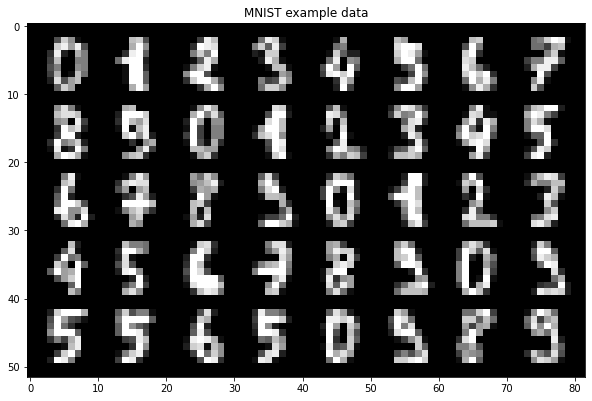

In [4]:
sample_index = 40
plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(digits.images[:sample_index]).unsqueeze(1), normalize=True).permute(1,2,0),cmap=plt.cm.gray_r,interpolation='nearest')
plt.title("MNIST example data");

# Implement a shallow neural network
We now start implementing a shallow neural network. We first define the individual functions to ensure that they run as expected. Next, we add these functions to construct the neural network class and train the model.

## Predefined settings
Here we define some settings to be used later. 

* EPSILON: To avoid instability if probability equals 0. 
* INPUT_SIZE: Define the shape of the input.
* HIDDEN_SIZE: Number of neurons in the hidden layer.
* OUTPUT_SIZE: Number of classes to calculate the final probability scores.

In [5]:
# Creating data set
EPSILON = 1e-6
INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 10
OUTPUT_SIZE = len(np.unique(y_train))

## One-hot encoding
To differentiate between the classes from the dataset, we apply the one-hot encoding to the labels based on the unique length of the labels.

In [6]:
def one_hot(n_classes, y):
    if isinstance(n_classes, int) and isinstance(y, (int,list, np.ndarray, np.int32)):
        return np.eye(n_classes, dtype=np.int32)[y]
    else:
        raise ValueError('Wrong type of data')

## Activation functions
The first coding task is to implement three activation functions using the given formulas below. Verify the output based on the given input.

1. **TODO:** Implement **sigmoid** 
2. **TODO:** Implement **dsigmoid** which is the element-wise **derivitate of sigmoid** 
3. **TODO:** Implement **softmax** 

$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$

$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$

$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$

In [7]:
def sigmoid(x):
    #TODO
    
    return 1 / (1 + (np.exp(-x)))

In [8]:
def dsigmoid(X):
    #TODO

    return sigmoid(X) * (1 - sigmoid(X))

In [9]:
def softmax(X):
    #TODO

    if isinstance(X[0], np.ndarray):
        return [softmax(x) for x in X]
    else:
        exp = np.exp(X)
        return exp / np.sum(exp)

To test your implementations, please run the following code and see if the resulting plot is the same as the expected result given below.

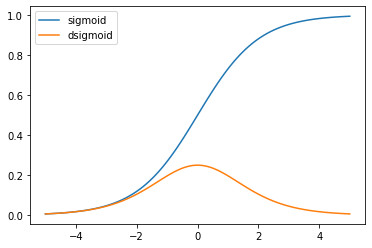

In [10]:
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

### Expected result - sigmoid and dsigmoid
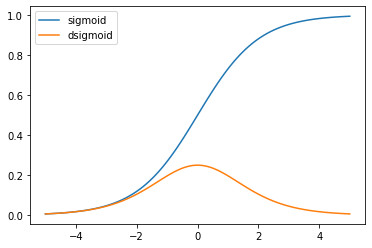


### Test Softmax
For the verification of the softmax implementation, you can run the asserts below to see if the results are the same. 

In [11]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])

assert np.allclose(softmax([10, 2, -3]), [9.99662391e-01, 3.35349373e-04, 2.25956630e-06]), "Wrong answer!"
assert np.allclose(softmax(X),[[9.99662391e-01, 3.35349373e-04, 2.25956630e-06],[2.47262316e-03, 9.97527377e-01, 1.38536042e-11]]), "Wrong answer!"
assert (np.sum(softmax(X), axis=1) == [1,1]).all(), "Probability not equal to 1"

## Cross Entropy Loss

Cross-entropy loss is defined as  $l = L_{CE} = - \frac{1}{N}\sum_{n=1}^N\sum_{i=1}^M t_{ni} \log(p_{ni})$ (See the Lecture 3 slides) where $N$ is the number of samples, $M$ is the number of classes, $t$ is the target vector in one hot encoding, $t_{ni}$ is the $i^{th}$ value of target vector for $n^{th}$ sample and finally $p_{ni}$ is the probability. For now, implement the loss equation, once you are through the subsection Backpropagation, implement the gradient of loss with respect to logit $\frac{dl}{dz\_o}$. If ```return_grad``` is true, the function should return both the loss and its gradient, otherwise only loss. 

In [195]:
class CrossEntropyLoss():
    def __call__(self, logit, target, return_grad=False):
        # TODO: generate prediction probability using softmax
        # the probability vector you generated is the p in the equation above. 
        # complete the equation implementation 
        # if return_grad is true, the gradient of loss with respect to logit has to be returned. 
        # in the Backpropagation subsection you will derive dl/dz_o 
        # once you derive dl/dz_o, implement it here as the gradient of loss with respect to the logit
        y_pred = softmax(logit)
        if return_grad:
            loss = np.mean(np.multiply(target, np.log(y_pred)))
        
            gradient = np.dot(logit, loss) / logit.shape[0]
            return  loss, gradient
        else:
            loss = np.sum(target * np.log(y_pred))
            return  - loss / logit.shape[0]
        
        
    

### Test CrossEntropyLoss


In [196]:
loss = CrossEntropyLoss() 
logit = np.array([[-0.74578508, -0.46463579, -0.18976292],
       [ 0.84814649, -1.08234052, -0.56845018],
       [ 1.0468291 ,  1.58556192, -0.09483985],
       [ 0.27190717,  0.35000514, -0.11552652]])
target = one_hot(3, [0,2,1,1]) 
loss(logit, target)
assert np.isclose(loss(logit, target), 1.1638533556625452)

## What happens inside our Model
We will use the following functions for in our Feedforward network
* $\mathbf{z\_h} = \mathbf{W}\_h \times \mathbf{x} + \mathbf{b\_h}$
* $\mathbf{a\_h} = sigmoid(\mathbf{z\_h}) $
* $\mathbf{z\_o} = \mathbf{W\_o} \times \mathbf{a\_h} + \mathbf{b\_o}$

Here, $x$ is the input data, $W\_h$ is the weight of hidden layer, $b\_h$ is the bias of the hidden layer, $W\_o$ is the weight of output layer, and $b\_o$ is the bias of output layer. $z\_h$ is the pre-activation output of hidden layer, $a\_h$ is the activation of the hidden layer, $z\_o$ is the output of the model (output from the final layer). $z_o$ is also known as logit. This logit will be fed to the CrossEntropyLoss object to calculate the loss. 


<img src="../data/images/current_model.png" width="800">

## Optimizer: SGD

SGD stands for stochastic gradient descent. It is a common choice for optimizing deep learning models. A plain SGD works according to the following equation. 

$$W_i = W_i - \alpha \times \nabla W_{i}L $$

where $W_i$ is the weight of layer $i$, $\alpha$ is the learning rate, $\nabla W_{i}L$ is the gradient of loss function $L$ with respect to $W_i$


**TODO:** Complete the SgdForSoftMax class. This class will only support the loss using a SoftMax function. You need to implement ```step``` and ```calculate_grads``` functions. Read the **TODOs** inside these function for more instructions. You can change the structure of the class as long as these function are returning the desired output.  

### Backpropagation

To calculate the gradient inside the ```calculate_grads``` function, we will backpropagate the loss through the layers of the neural network. To do back propagation, we have to re-visit basic calculus. Here are some basic rules for taking derivative: 

1. $\frac{d}{dx} \log (x) = \frac{1}{x}$
2. $\frac{d}{dx} e^x = e^x$
3. $\frac{d}{dx} (ax + b) = a$
4. $\frac{d}{dX} (AX + B) = A^T $ where $A$, $X$ and $B$ are matrix
5. $\frac{d}{dx}f(x)g(x) = f(x)\frac{d}{dx}g(x) + g(x)\frac{d}{dx}f(x)$ (product rule)
6. $\frac{d}{dx}\frac{f(x)}{g(x)} = \frac{g(x)\frac{d}{dx}f(x) - f(x)\frac{d}{dx}g(x)}{g(x)^2}$ (quotient rule)
7. $\frac{da}{dx} = \frac{da}{dy}\frac{dy}{dx}$ (chain rule)


**TODO:** Derive $\frac{dl}{dz\_o}$ and implement this in the ```__call__``` function of ```CrossEntropyLoss``` class above. Use it to calculate following gradients. 

* $\huge \frac{dl}{dW\_h} = \frac{dl}{dz\_o}\frac{dz\_o}{da\_h}\frac{da\_h}{dz\_h}\frac{dz\_h}{dW\_h}$


* $\huge \frac{dl}{db\_h}= \frac{dl}{dz\_o}\frac{dz\_o}{da\_h}\frac{da\_h}{dz\_h}\frac{dz\_h}{db\_h}$


* $\huge\frac{dl}{dW\_o} = \frac{dl}{dz\_o}\frac{dz\_o}{dW\_o}$


* $\huge\frac{dl}{dW\_o} = \frac{dl}{dz\_o}\frac{dz\_o}{db\_o}$

Don't forget to write all your hardworks in the Report.ipynb

In [197]:
class SgdForSoftMax(): 
    def __init__(self, params, lr):
        self.params = params 
        self.lr = lr 
        self.loss = None 
        self.dloss = None 
        self.x = None
        self.a_h = None
        self.z_h = None 
    
    def step(self, loss, dloss, x, a_h, z_h):
        self.loss = loss 
        self.dloss = dloss 
        self.x = x
        self.a_h = a_h
        self.z_h = z_h 
        # TODO : retrieve gradient using calculate_grads function
        grads = self.calculate_grads()
        W_h = grads['W_h']
        W_o = grads['W_o']
        b_h = grads['b_h']
        b_o = grads['b_o']
        # TODO : update self.params according to the SGD equation written above 
        self.params['W_h'] = self.params['W_h'] - self.lr * W_h
        self.params['W_o'] = self.params['W_o'] - self.lr * W_o
        self.params['b_h'] = self.params['b_h'] - self.lr * b_h
        self.params['b_o'] = self.params['b_o'] - self.lr * b_o
        return NotImplemented
            
    def calculate_grads(self):
        # TODO: Calculate dl_W_h: gradient of loss with respect to the weight of hidden layer
        loss = CrossEntropyLoss() 
        W_h = np.random.uniform(size=(self.x.shape[0], HIDDEN_SIZE), high=0.01, low=-0.01)
        dl_dW_h = loss(W_h, self.x, True)
        # TODO: Calculate dl_b_h: gradient of loss with respect to the bias of hidden layer
        b_h = np.zeros(HIDDEN_SIZE)
        dl_db_h = loss(b_h, self.x, True) 
        # TODO: Calculate dl_W_o: gradient of loss with respect to the weight of output layer
        W_o = np.random.uniform(size=(HIDDEN_SIZE, OUTPUT_SIZE), high=0.01, low=-0.01)
        dl_dW_o = loss(W_o, self.x, True)  
        # TODO: Calulate dl_b_o: gradient of loss with respect to the bias of output layer
        b_o = np.zeros(OUTPUT_SIZE)
        dl_db_o = loss(b_o, self.x, True)  
        return {
            "W_h": dl_dW_h, "b_h": dl_db_h,
            "W_o": dl_dW_o, "b_o": dl_db_o
        }

## Predict
To predict we calculate the indices of the maximum values along an axis. on the forward pass. However we need to consider if the input is 1D (one input) or 2D (multiple inputs). We therefore check if len(X.shape) == 1, otherwise we extract the indices of the maximum values along axis=1.

In [198]:
def predict(X, model):
    return np.argmax(model(X)) if len(X.shape) == 1 else np.argmax(model(X), axis=1)

## Metric
To evaluate the network we are going to use accuracy.

In [199]:
def accuracy(y_preds, y_truth):
    return np.mean(y_preds == y_truth)

## Neural network
Our neural network contains one hidden layer. There is an output layer.
**TODO:** Complete the ```forward``` function. 

In [200]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=( output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X, keep_activations=False):
        #TODO: Re-visit "What happens inside our Model" subsection and implement 
        # z_h, a_h, and z_o. If keep_activations is true, return z_o, a_h, z_h (in this order)
        # else return z_o only. 
        z_h = np.dot(X, self.W_h) + self.b_h
        a_h = sigmoid(z_h)
        z_o = np.dot(a_h, self.W_o) + self.b_o
        z_o = softmax(z_o)

        if keep_activations:
            return z_o, a_h, z_h
        else:
            return z_o
    
    def parameters(self):
        return {
            "W_h": self.W_h, "b_h": self.b_h,
            "W_o": self.W_o, "b_o": self.b_o
        }
    
    def __call__(self, X, keep_activations=False):
        return self.forward(X, keep_activations)

## Training
We define a ```train``` function that trains the model and returns the losses as a list. 

In [201]:
def train(model, x_train, y_train, n_epochs, optimizer, criterion):
    losses = list() 
    for epoch in range(n_epochs):
        epoch_loss = 0.0 
        for i, (x, y) in enumerate(zip(x_train, y_train)):
            z_o, a_h, z_h = model(x, keep_activations=True)
            y_oh = one_hot(OUTPUT_SIZE, y)
            loss, dl_dzo = criterion(z_o, y_oh, return_grad=True)
            epoch_loss += loss 
            optimizer.step(loss, dl_dzo, x, a_h, z_h) 
        epoch_loss /= len(x_train) 
        losses.append(epoch_loss) 
    return losses 

### Preparing Model, Optimizer and Criterion 
We instantiate the classes for model, optimizer and criterion. 

In [202]:
model = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
optimizer= SgdForSoftMax(model.parameters(), lr=1e-3) 
criterion = CrossEntropyLoss() 

### Finally train the model with training data

In [203]:
losses = train(model, X_train, y_train, 15, optimizer, criterion)

ValueError: operands could not be broadcast together with shapes (64,) (64,10) 

## Visualize the result
With the help of the following plots we can observe the training performance of our neural network. 

In [18]:
plt.plot(losses)
plt.xlabel('Loss Value')
plt.ylabel('Epoch')
plt.show()

### Test the model performance on Test Set

In [ ]:
acc = accuracy(y_preds=predict(X_test, model), y_truth=y_test)
print(acc)

**Question:** Can the result be improved? \
**Question:** How many epochs are reasonable to run?\
**Question:** How does the performance change if we modify the learning rate?\

## Bonus Task
Shift the test images by 2 pixels to left, now feed this new test data to accuracy function. Compare the result with original test data. 